In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
import os
sys.path.append('../src/')
from data_utils import *

In [4]:
def draw_point_cloud(ax,points,axes=[0,1,2],point_size=0.1,xlim3d=None,ylim3d=None,zlim3d=None):
    axes_limits = [
        [-20,80],
        [-20,20],
        [-3,3]
    ]
    axes_str = ['X','Y','Z']
    ax.grid(False)
    
    ax.scatter(*np.transpose(points[:,axes]),s=point_size,c=points[:,3],cmap='gray')
    ax.set_xlabel('{}axis'.format(axes_str[axes[0]]))
    ax.set_xlabel('{}axis'.format(axes_str[axes[1]]))
    if len(axes) >2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.set_zlabel('{}axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)


            

In [5]:
DATA_PATH = '/home/rpf/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/'

points = read_point_cloud(os.path.join(DATA_PATH,'velodyne_points/data/%010d.bin'%0))

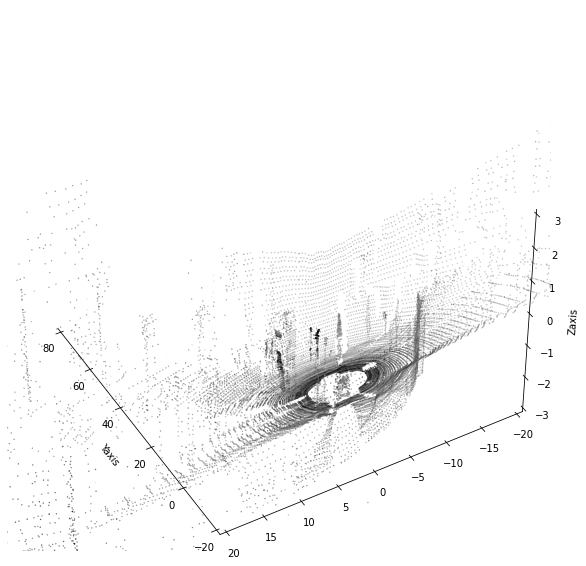

In [6]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40,150)
draw_point_cloud(ax, points[::5])

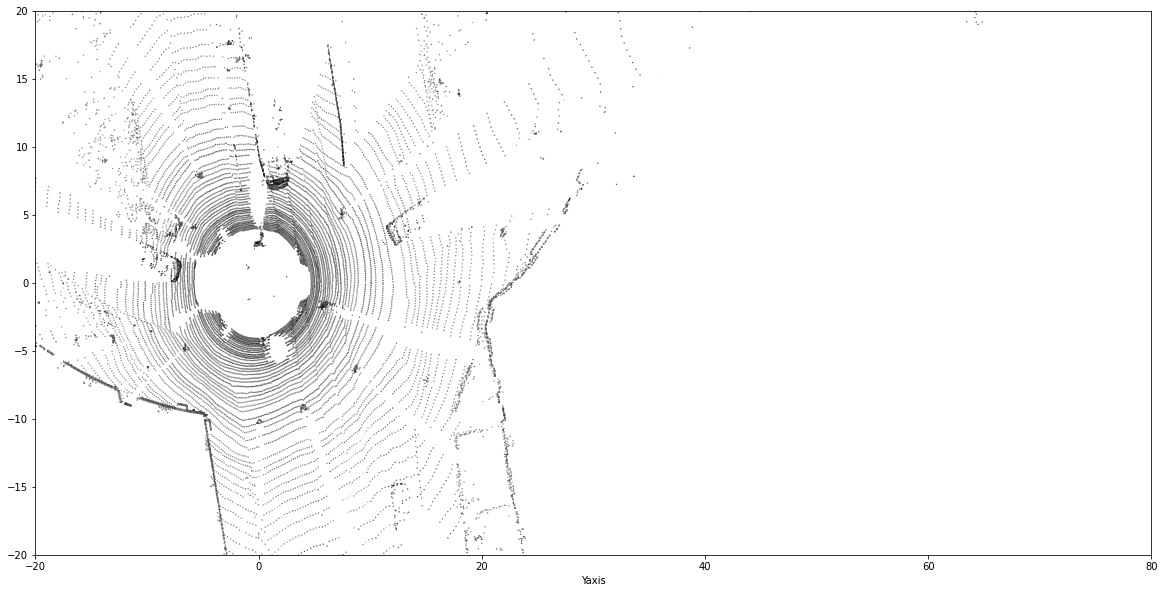

In [7]:
fig,ax = plt.subplots(figsize=(20,10))
draw_point_cloud(ax,points[::5],axes=[0,1])


In [8]:
df_tracking = read_tracking('/home/rpf/data/kitti/training/label_02/0000.txt')
df_tracking.head()


,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456


In [27]:
def compute_3d_cam2(h,w,l,x,y,z,yaw):
    R = np.array([[np.cos(yaw),0,np.sin(yaw)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2] 
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]
    corners_3d_cam2 = np.dot(R,np.vstack([x_corners,y_corners,z_corners]))
    corners_3d_cam2 += np.vstack([x,y,z])
    return corners_3d_cam2

In [28]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

In [29]:
corners_3d_cam2 = compute_3d_cam2(*df_tracking.loc[2,['height','width','length','pos_x','pos_y','pos_z','rot_y']])
                                                   

In [30]:
corners_3d_cam2.shape

(3, 8)

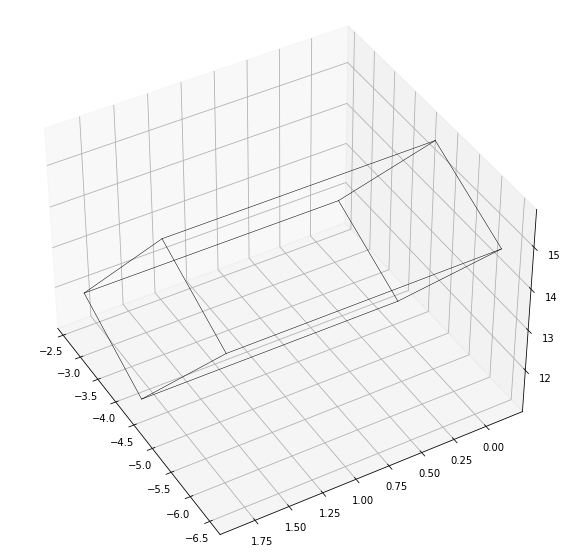

In [31]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111,projection ='3d')
ax.view_init(40,150)
draw_box(ax,(corners_3d_cam2))


In [32]:
from kitti_util import *

In [33]:
calib = Calibration('/home/rpf/data/kitti/RawData/2011_09_26/',from_video=True)

corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T).T
corners_3d_velo

array([[15.12424719, 16.06928938, 12.27779014, 11.33274795, 15.10334837,
        16.04839056, 12.25689133, 11.31184914],
       [ 6.49985556,  4.9406537 ,  2.64287284,  4.2020747 ,  6.47872485,
         4.91952299,  2.62174213,  4.18094399],
       [-1.70710774, -1.71370686, -1.7776097 , -1.77101058,  0.29267156,
         0.28607244,  0.2221696 ,  0.22876872]])

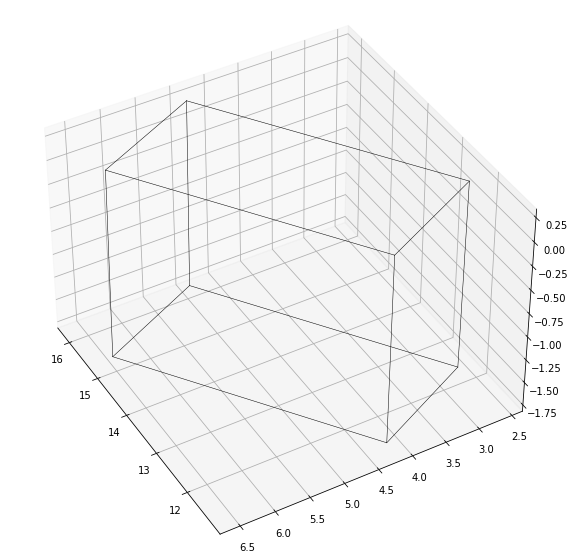

In [34]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40,150)
draw_box(ax,corners_3d_velo)

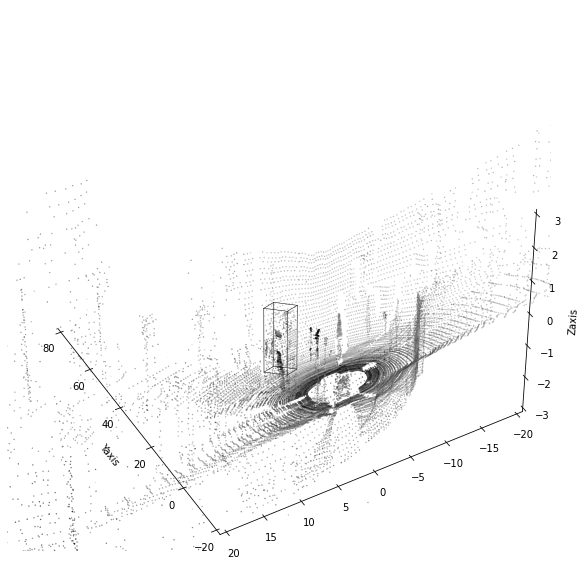

In [35]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(40,150)
draw_point_cloud(ax,points[::5])
draw_box(ax,corners_3d_velo)

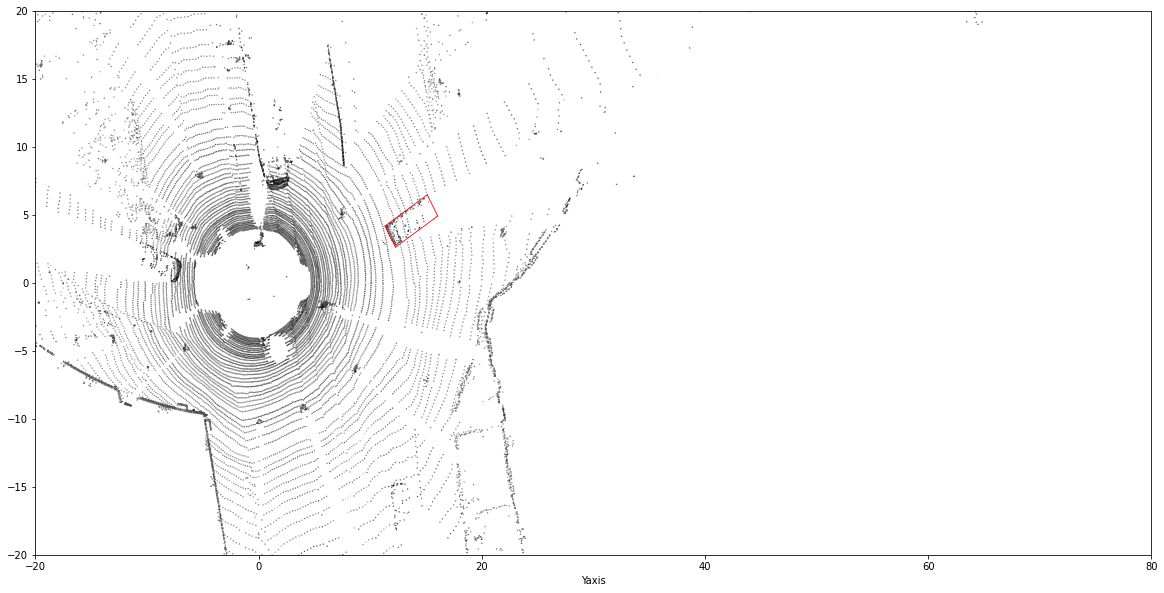

In [36]:
fig ,ax = plt.subplots(figsize=(20,10))
draw_point_cloud(ax,points[::5],axes=[0,1])
draw_box(ax,corners_3d_velo,axes=[0,1],color='r')